In [1]:
import pandas as pd
import joblib

In [2]:
pd.set_option("display.float_format","{:.2f}".format)

In [3]:
df = pd.read_csv("data/prepared_data.csv")

In [4]:
df.head()

,Id,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim,age_group,bmi_category
0,1,39.00,1,23.20,91,1,0,0,southeast,1121.87,31-45,Normal
1,2,24.00,1,30.10,87,0,0,0,southeast,1131.51,18-30,Obese
2,8,19.00,1,41.10,100,0,0,0,northwest,1146.80,18-30,Obese
3,9,20.00,1,43.00,86,0,0,0,northwest,1149.40,18-30,Obese
4,10,30.00,1,53.10,97,0,0,0,northwest,1163.46,18-30,Obese


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = df[["age", "gender", "bmi", "bloodpressure", "diabetic", "children", "smoker"]]
y = df["claim"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Scaling numerical features
from sklearn.preprocessing import StandardScaler

num_cols = ["age", "bmi", "bloodpressure", "children"]
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [9]:
joblib.dump(scaler, "scaler/scaler.pkl")

['scaler/scaler.pkl']

In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1065, 7) (1065,)
(267, 7) (267,)


In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

In [12]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return {"R2" : r2, "MAE" : mae, "RMSE" : rmse}

In [13]:
results = {}

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)
results["Linear Regression"] = evaluate_model(lr, X_train, X_test, y_train, y_test)
print("Linear Regression model trained")

Linear Regression model trained


In [15]:
best_poly_model = None
best_poly_score = -np.inf

for degree in [2,3]:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    poly_lr = LinearRegression()
    poly_lr.fit(X_train_poly, y_train)

    score = poly_lr.score(X_test_poly, y_test)

    if score > best_poly_score:
        best_poly_score = score
        best_poly_model = (degree, poly, poly_lr)

degree, poly, poly_lr = best_poly_model

results[f"Polynomial Regression (deg = {degree})"] = evaluate_model(poly_lr, poly.fit_transform(X_train), poly.transform(X_test), y_train, y_test)

print("Polynomial Regression models are trained")

Polynomial Regression models are trained


In [16]:
rf = RandomForestRegressor()

rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

rf_grid = GridSearchCV(estimator=rf, param_grid=rf_params, cv=3, scoring="r2", n_jobs=-1, verbose=0)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

results["Random Forest"] = evaluate_model(best_rf, X_train, X_test, y_train, y_test)

print("Random Forest training is completed, best parameters", rf_grid.best_params_)

Random Forest training is completed, best parameters {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [17]:
svr = SVR()

svr_params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [1, 10, 50],
    "epsilon": [0.1, 0.2, 0.5],
    "degree": [2,3]
}

svr_grid = GridSearchCV(estimator=svr, param_grid=svr_params, cv=3, scoring="r2", n_jobs=-1, verbose=0)
svr_grid.fit(X_train, y_train)
best_svr = svr_grid.best_estimator_

results["SVR"] = evaluate_model(svr_grid, X_train, X_test, y_train, y_test)

print("SVR training is completed, best parameters", svr_grid.best_params_)

SVR training is completed, best parameters {'C': 50, 'degree': 2, 'epsilon': 0.5, 'kernel': 'linear'}


In [18]:
xgb = XGBRegressor(objective="reg:squarederror")

xgb_params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
}

xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=3, scoring="r2", n_jobs=-1, verbose=0)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

results["XGBoost"] = evaluate_model(xgb_grid, X_train, X_test, y_train, y_test)
print("XGBoost training is completed, best parameters", xgb_grid.best_params_)

XGBoost training is completed, best parameters {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


In [19]:
results

{'Linear Regression': {'R2': 0.7186402865210724,
  'MAE': 5034.263198897407,
  'RMSE': np.float64(6368.137982018984)},
 'Polynomial Regression (deg = 2)': {'R2': 0.7757814325424963,
  'MAE': 4426.321815178741,
  'RMSE': np.float64(5684.827554251739)},
 'Random Forest': {'R2': 0.8231155234768534,
  'MAE': 3882.898620901251,
  'RMSE': np.float64(5049.244123988171)},
 'SVR': {'R2': 0.4979929465562679,
  'MAE': 5916.9074098768515,
  'RMSE': np.float64(8506.21622300923)},
 'XGBoost': {'R2': 0.8323172161437656,
  'MAE': 3820.3895535975535,
  'RMSE': np.float64(4916.157026030382)}}

In [20]:
results_df = pd.DataFrame(results).T.sort_values(by="R2", ascending=False)
results_df

,R2,MAE,RMSE
XGBoost,0.83,3820.39,4916.16
Random Forest,0.82,3882.90,5049.24
Polynomial Regression (deg = 2),0.78,4426.32,5684.83
Linear Regression,0.72,5034.26,6368.14
SVR,0.50,5916.91,8506.22


In [21]:
models = {
    "Linear Regression": lr,
    "Polynomial Regression": poly_lr,
    "Random Forest": best_rf,
    "SVR": best_svr,
    "XGBoost": best_xgb,
}

In [22]:
best_r2 = results_df["R2"].max()
best_r2

np.float64(0.8323172161437656)

In [23]:
top_model = results_df[results_df["R2"] == best_r2]

In [24]:
top_model

,R2,MAE,RMSE
XGBoost,0.83,3820.39,4916.16


In [25]:
best_model = models[top_model.index[0]]
best_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [26]:
joblib.dump(best_model, "best_model/best_model.pkl")
print(f"Best model selected: {top_model.index[0]}")

Best model selected: XGBoost


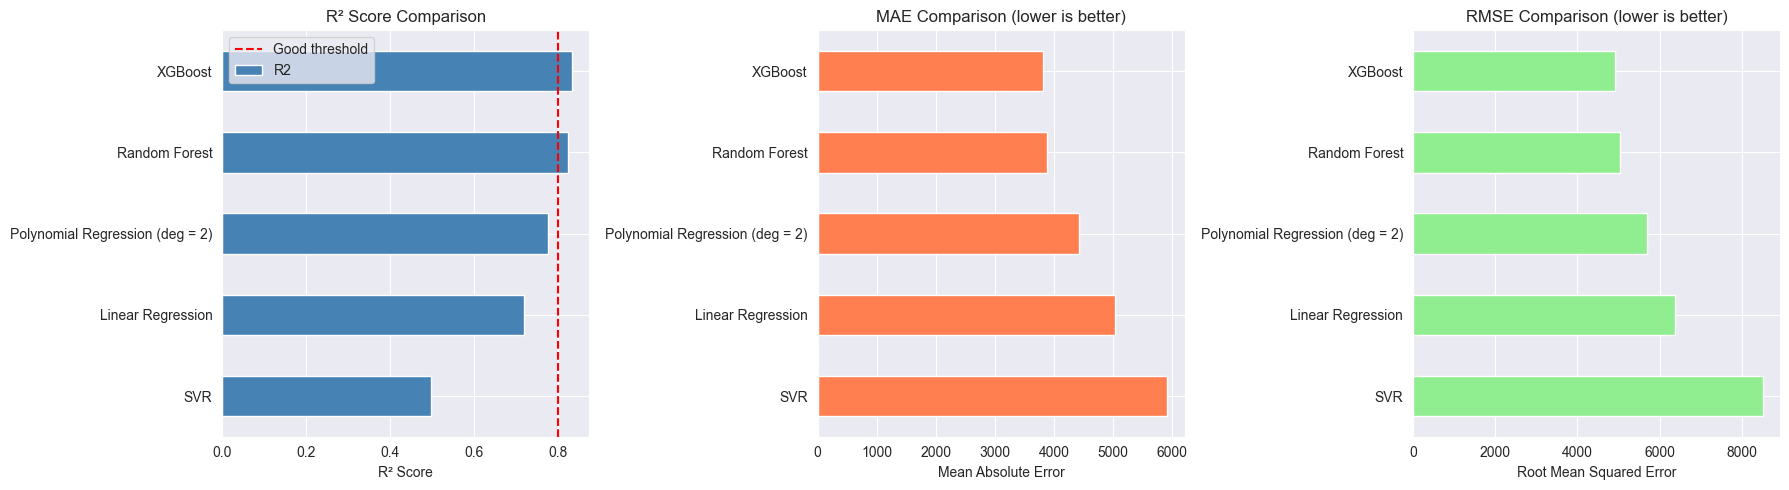

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R2 Score
results_df.sort_values('R2').plot(kind='barh', y='R2', ax=axes[0], color='steelblue', legend=False)
axes[0].set_xlabel('R² Score')
axes[0].set_title('R² Score Comparison')
axes[0].axvline(x=0.8, color='red', linestyle='--', label='Good threshold')
axes[0].legend()

# MAE
results_df.sort_values('MAE', ascending=False).plot(kind='barh', y='MAE', ax=axes[1], color='coral', legend=False)
axes[1].set_xlabel('Mean Absolute Error')
axes[1].set_title('MAE Comparison (lower is better)')

# RMSE
results_df.sort_values('RMSE', ascending=False).plot(kind='barh', y='RMSE', ax=axes[2], color='lightgreen', legend=False)
axes[2].set_xlabel('Root Mean Squared Error')
axes[2].set_title('RMSE Comparison (lower is better)')

plt.tight_layout()
plt.show()